In [1]:
from web3 import Web3
import pandas as pd
import datetime
from concurrent.futures import ProcessPoolExecutor
import numpy as np
from datetime import datetime
import logging, os, json
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
file_path = 'block_data/compiled_eth_tx_small.csv'
df = pd.read_csv(file_path, nrows=1000, encoding='ISO-8859-1', on_bad_lines='skip', quotechar='"', escapechar='\\')

df.groupby('block_number').sum()

/var/folders/fn/zk93lv7x5qb0fyk32l1610240000gn/T/ipykernel_85228/744034763.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('block_number').sum()


,gas_price,gas_used,gas_price_gwei
block_number,,,
18937472,2846688809041,13212971,2846.688809
18937473,2926988820430,15941349,2926.988820
18937474,2221419869767,12270298,2221.419870
18937475,2466057233860,11904485,2466.057234
18937476,4966469407128,23180688,4966.469407
18937477,2570138754368,11505735,2570.138754
18937478,2976241507164,8286108,2976.241507


In [3]:
aggregated_df = pd.DataFrame()

chunk_size = 10**6  

for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    chunk['gasPrice_eth'] = chunk['gas_price_gwei'] * 10**-9
    chunk['tcost_usd']    = chunk['gasPrice_eth'] * chunk['gas_used']
    
    numeric_cols = ['gas_price_gwei', 'gas_used', 'gasPrice_eth', 'tcost_usd']
    grouped = chunk.groupby(['block_number', 'timestamp'], as_index=True)[numeric_cols]
    
    # aggregations = {
    #     'count': 'count',
    #     'max': 'max',
    #     'std': 'std',
    #     'skew': 'skew',
    #     'mean': 'mean',
    #     'min': 'min',
    #     '25%': lambda x: x.quantile(0.25),
    #     '50%': lambda x: x.quantile(0.5),
    #     '75%': lambda x: x.quantile(0.75),
    #     'kurtosis': pd.DataFrame.kurt
    # }
    # chunk_aggregated = grouped.agg(aggregations)
    chunk_aggregated = grouped.agg(['count', 'max', 'std', 'skew', 'mean', 'min'])
    
    aggregated_df = pd.concat([aggregated_df, chunk_aggregated])
    
aggregated_df.to_csv('block_data/block_stats.csv')

In [4]:
aggregated_df#['tcost_usd']#[['max','mean', 'min']]s

gas_price_gwei                           \
                                          count          max         std   
block_number timestamp                                                     
18937472     2024-01-05 00:18:23           1305    75.000000    7.659844   
18937473     2024-01-05 00:18:35           1278   149.732461   14.184943   
18937474     2024-01-05 00:18:47           1062    45.391739    4.435548   
18937475     2024-01-05 00:18:59           1143   147.203487   12.829451   
18937476     2024-01-05 00:19:11           2259   374.966944   23.534715   
...                                         ...          ...         ...   
18938317     2024-01-05 03:09:35            745  1499.449773  132.184032   
18938318     2024-01-05 03:09:47            588   742.900175   61.933466   
18938319     2024-01-05 03:09:59            432  7411.745725  614.986213   
18938320     2024-01-05 03:10:11            390    90.000000    8.725008   
18938321     2024-01-05 03:10:23            148   335.345259   26.378159   

                                                                  gas_used  \
                                       skew       mean        min    count   
block_number timestamp                                                       
18937472     2024-01-05 00:18:23   4.837095  19.632337  16.744342     1305   
18937473     2024-01-05 00:18:35   6.634795  20.612597  16.494987     1278   
18937474     2024-01-05 00:18:47   3.685368  18.825592  16.624383     1062   
18937475     2024-01-05 00:18:59   8.315077  19.417773  16.246220     1143   
18937476     2024-01-05 00:19:11  13.837969  19.786731  15.827133     2259   
...                                     ...        ...        ...      ...   
18938317     2024-01-05 03:09:35   9.661868  35.073946  15.359143      745   
18938318     2024-01-05 03:09:47  10.868395  23.664993  15.023936      588   
18938319     2024-01-05 03:09:59  11.898000  69.810088  14.953303      432   
18938320     2024-01-05 03:10:11   5.164169  18.169719  14.579046      390   
18938321     2024-01-05 03:10:23  11.954765  18.489135  14.898094      148   

                                                                    ...  \
                                      max            std      skew  ...   
block_number timestamp                                              ...   
18937472     2024-01-05 00:18:23  1575687  167887.936070  6.606855  ...   
18937473     2024-01-05 00:18:35  1870412  182531.120961  6.899476  ...   
18937474     2024-01-05 00:18:47   728368  114675.673926  2.633806  ...   
18937475     2024-01-05 00:18:59   890466  107102.947184  3.763585  ...   
18937476     2024-01-05 00:19:11  1325758  132843.496656  6.191157  ...   
...                                   ...            ...       ...  ...   
18938317     2024-01-05 03:09:35   986367  109294.421477  4.476630  ...   
18938318     2024-01-05 03:09:47   988162  135068.966392  3.984647  ...   
18938319     2024-01-05 03:09:59  1034752  138734.753636  4.889862  ...   
18938320     2024-01-05 03:10:11   993736  133439.443078  4.403995  ...   
18938321     2024-01-05 03:10:23  1047783  130161.602220  3.648364  ...   

                                  gasPrice_eth                     \
                                           std skew          mean   
block_number timestamp                                              
18937472     2024-01-05 00:18:23  7.659844e-09  0.0  1.963234e-08   
18937473     2024-01-05 00:18:35  1.418494e-08  0.0  2.061260e-08   
18937474     2024-01-05 00:18:47  4.435548e-09  0.0  1.882559e-08   
18937475     2024-01-05 00:18:59  1.282945e-08  0.0  1.941777e-08   
18937476     2024-01-05 00:19:11  2.353471e-08  0.0  1.978673e-08   
...                                        ...  ...           ...   
18938317     2024-01-05 03:09:35  1.321840e-07  0.0  3.507395e-08   
18938318     2024-01-05 03:09:47  6.193347e-08  0.0  2.366499e-08   
18938319     2024-01-05 03:09:59  6.149862e-07  0.0  6.981009e-08

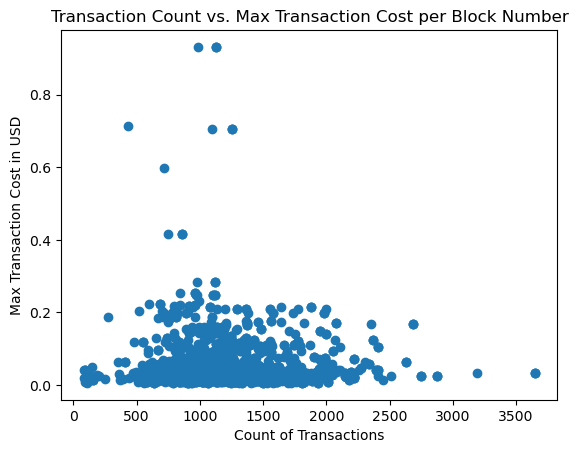

In [5]:

final_aggregated_df = aggregated_df['tcost_usd']

# Now you can plot
plt.scatter(final_aggregated_df['count'], final_aggregated_df['max'])
plt.xlabel('Count of Transactions')
plt.ylabel('Max Transaction Cost in USD')
plt.title('Transaction Count vs. Max Transaction Cost per Block Number')
plt.show()


In [6]:
df[['timestamp','block_number', 'gas_price', 'gas_used', 'gasPrice_eth', 'tcost_usd']].groupby(['block_number', 'timestamp']).agg(['max'])


KeyError: "['gasPrice_eth', 'tcost_usd'] not in index"

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it's already loaded

# Plotting the graph of max tcost per block number
# Find the max tcost_usd for each block number
max_tcost_per_block = df.groupby('block_number')['tcost_usd'].max().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(max_tcost_per_block['block_number'].astype(str), max_tcost_per_block['tcost_usd'], color='skyblue')
plt.xlabel('Block Number')
plt.ylabel('Max Transaction Cost in USD')
plt.title('Max Transaction Cost (USD) per Block Number')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
df[df.block_number == 18937474].sort_values('tcost_usd')['tcost_usd'].hist(bins=50)

In [ ]:
plt.scatter(df.groupby('block_number')['tcost_usd'].count(), df.groupby('block_number')['tcost_usd'].max())

In [ ]:
# perfect linearilty
plt.scatter(df.groupby('block_number')['tcost_usd'].skew(), df.groupby('block_number')['tcost_usd'].max())

In [ ]:
# here we can see its not linear
plt.scatter(df.groupby('block_number')['gas_used'].skew(), df.groupby('block_number')['tcost_usd'].max())

In [ ]:
df.groupby('block_number').mean()